## Dividend_Cut_Prediction

As I briefed in last version, I will try to use most of features given in datset and filter out relevent one to create a model for prediction

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('ds_assessment_data_2008_2016.csv')

In [3]:
#df.head()

In [4]:
t_data = df.copy()

In [5]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Columns: 107 entries, id to financial_health_score
dtypes: float64(104), int64(1), object(2)
memory usage: 715.6+ KB


In [6]:
t_data.shape

(856, 107)

In [7]:
t_data = t_data.groupby('id').filter(lambda x: x.shape[0] >2)

In [8]:
t_data['div_cut']=0
t_data['Dividend_returns'] = t_data['Dividend_returns'].fillna(0)
t_data['div_cut'] = t_data['Dividend_returns'].apply(lambda x: 0 if x>=0.095 else 1)

Let's first interpolate the data with some tricks since there are too many features with missing values.As per my understanding of the data, field values are more closer within it's respective datset. Initially we interpolate Nan by grouping with ID then with financial health score. This we will get rid of most of the Nans. We still be left with many Nans and inf so we will be dropping those columns if they are not necessary.

In [9]:
t_data = t_data.groupby('id').apply(lambda x:x.interpolate(method='linear', limit_direction ='both'))

In [10]:
t_data = t_data.groupby('financial_health_score').apply(lambda x:x.interpolate(method='linear', limit_direction ='both'))

In [11]:
#t_data[pd.isnull(t_data).any(axis=1)]

In [12]:
all_data_na = (t_data.isnull().sum() / len(t_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
EPSRD_returns,31.279621
EBITDAR_returns,30.094787
REV_TOT_returns,17.298578
EPS_EX_XORD_returns,17.298578
BPS_TANG_returns,17.298578
REV_TOT,17.298578
EPS_EX_XORD,17.298578
GW_TOT_returns,4.028436
FCF_returns,1.303318
MAINT_CAPEX_returns,0.710900


Text(0.5,1,'Percent missing data by feature')

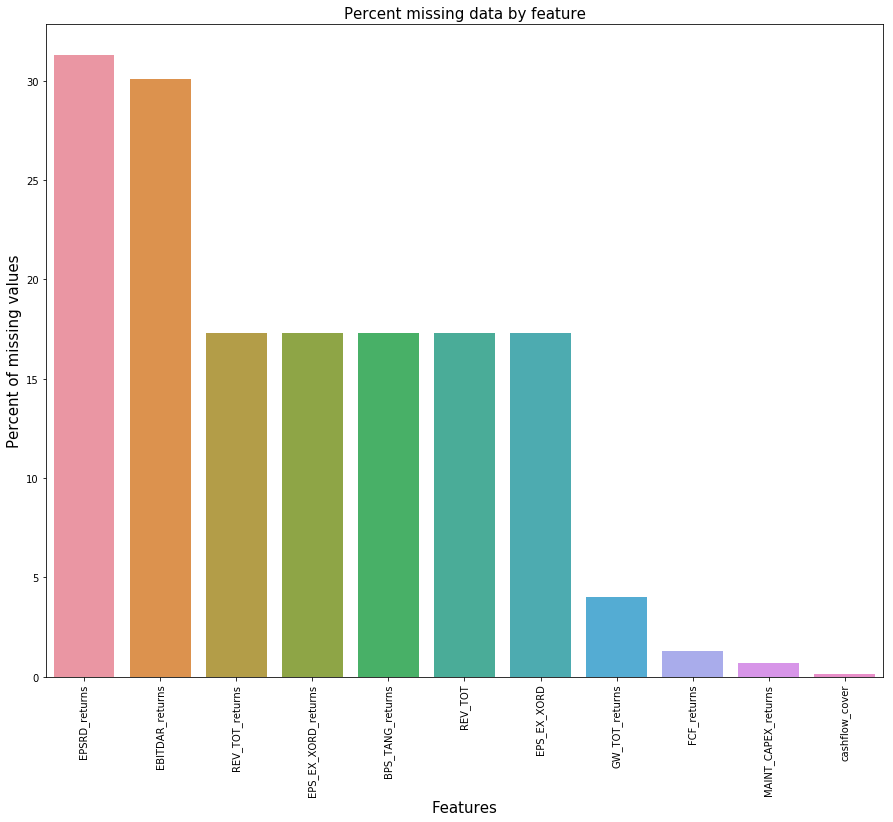

In [13]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Now we can drop the features which still have null values as per above plot

In [14]:
trunc_data = t_data.drop(['EBITDAR_returns','EPSRD_returns','EPS_EX_XORD_returns','EPS_EX_XORD','REV_TOT_returns','GW_TOT_returns','FCF_returns','MAINT_CAPEX_returns','REV_TOT','BPS_TANG_returns'],axis=1)

If we check Nans most the Nans are gone.

In [15]:
#trunc_data.isnull().sum()

In [16]:
#trunc_data[trunc_data['cashflow_cover']==np.inf]

In [17]:
#trunc_data = t_data.drop(['ORGANICGROWTH_returns','EBITR_returns','S_M_EXP_returns','REV_TOT_returns','EBITDAR_returns','EPSRD_returns','EPS_EX_XORD_returns','EPS_EX_XORD','BPS_TANG','FCF_returns','GW_TOT_returns','MAINT_CAPEX_returns'],axis=1)

In [18]:
#trunc_data[pd.isnull(trunc_data).any(axis=1)]

In [19]:
#trunc_data = trunc_data.drop(['cashflow_cover','earnings_cover'],axis=1)

We can investigate further and found Nan and remove that row since we dealt with most the columns

In [20]:
for column in trunc_data.columns:
    if trunc_data[column].isnull().any():
        print('{0} has {1} null values'.format(column, trunc_data[column].isnull().sum()))

cashflow_cover has 1 null values


In [21]:
trunc_data = trunc_data[~np.isnan(trunc_data['cashflow_cover'])]

In [22]:
trunc_data.shape

(843, 98)

In [23]:
trunc_data = trunc_data.dropna()

In [24]:
trunc_data.head()

,id,calendar_end,fiscal_year_end_year,Dividend,Dividend_returns,ASSETS,BFNG,BPS,BPS_TANG,CAPEX,...,EPS_returns,SALES_returns,S_M_EXP_returns,payout_ratio,earnings_cover,cashflow_cover,debt_factor,profitability,financial_health_score,div_cut
0,c141,2010-12-31,2010,10.8,0.000000,0.053828,0.071493,1.468992,8.631104,0.020825,...,1.653659,0.45318,0.023301,0.263415,3.796296,1.985421,3.102335,0.003902,1.0,1
1,c141,2011-12-31,2011,11.4,0.055556,0.053828,0.071493,1.468992,8.631104,0.020825,...,1.653659,0.45318,0.023301,0.104779,9.543860,1.985421,3.102335,0.007134,1.0,1
2,c141,2012-12-31,2012,12.4,0.087719,0.053828,0.071493,1.468992,8.631104,0.020825,...,0.200368,0.05182,0.023301,0.094946,10.532258,1.985421,3.102335,0.002238,1.0,1
3,c141,2013-12-31,2013,13.2,0.064516,0.021877,-0.011041,1.468992,8.631104,0.013676,...,0.200368,0.05182,1.380952,0.094946,10.532258,0.828960,5.605094,0.002238,0.0,1
4,c141,2014-12-31,2014,17.6,0.333333,0.021877,-0.011041,1.468992,8.631104,0.013676,...,0.200368,0.05182,1.380952,0.094946,10.532258,0.828960,5.605094,0.002238,0.0,0


C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


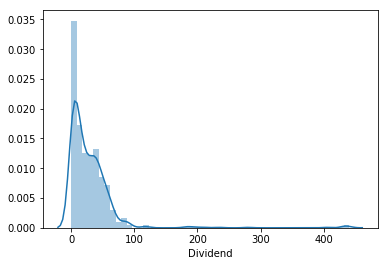

In [25]:
sns.distplot(trunc_data['Dividend'])

In [26]:
trunc_data=trunc_data[trunc_data['Dividend']<100] 

C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


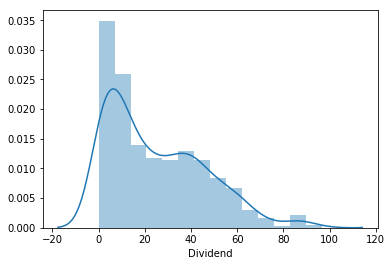

In [27]:
sns.distplot(trunc_data['Dividend'])

In [28]:
trunc_data['Dividend'] = np.log1p(trunc_data['Dividend'])

C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


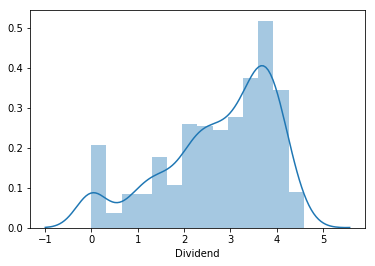

In [29]:
sns.distplot(trunc_data['Dividend'])

In [30]:
trunc_data = trunc_data.drop(['id','calendar_end','Dividend','Dividend_returns'],axis=1)

In [31]:
trunc_data.head()

,fiscal_year_end_year,ASSETS,BFNG,BPS,BPS_TANG,CAPEX,CFPS,CF_FIN,CF_INV,CF_OP,...,EPS_returns,SALES_returns,S_M_EXP_returns,payout_ratio,earnings_cover,cashflow_cover,debt_factor,profitability,financial_health_score,div_cut
0,2010,0.053828,0.071493,1.468992,8.631104,0.020825,1.689327,-0.188099,-0.053337,0.094890,...,1.653659,0.45318,0.023301,0.263415,3.796296,1.985421,3.102335,0.003902,1.0,1
1,2011,0.053828,0.071493,1.468992,8.631104,0.020825,1.689327,-0.188099,-0.053337,0.094890,...,1.653659,0.45318,0.023301,0.104779,9.543860,1.985421,3.102335,0.007134,1.0,1
2,2012,0.053828,0.071493,1.468992,8.631104,0.020825,1.689327,-0.188099,-0.053337,0.094890,...,0.200368,0.05182,0.023301,0.094946,10.532258,1.985421,3.102335,0.002238,1.0,1
3,2013,0.021877,-0.011041,1.468992,8.631104,0.013676,0.323453,0.048271,-0.047584,0.001599,...,0.200368,0.05182,1.380952,0.094946,10.532258,0.828960,5.605094,0.002238,0.0,1
4,2014,0.021877,-0.011041,1.468992,8.631104,0.013676,0.323453,0.048271,-0.047584,0.001599,...,0.200368,0.05182,1.380952,0.094946,10.532258,0.828960,5.605094,0.002238,0.0,0


In [32]:
data = trunc_data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

Now we will attemot to filter out important features from the given dataset so that model do not overfir with given data. There are many libraries which can help to select best features. I am using RFE and trying ti get get 30 best feature to model it. Again there are many other ways to do it. I am just trying to portay one the approaches due to time-constraints.

In [33]:

X = data.drop(['fiscal_year_end_year','div_cut'],axis=1)
y = data['div_cut']


In [34]:
X.columns

Index(['ASSETS', 'BFNG', 'BPS', 'BPS_TANG', 'CAPEX', 'CFPS', 'CF_FIN',
       'CF_INV', 'CF_OP', 'CURRENT_ASSETS', 'CURRENT_LIABILITIES',
       'DEPR_AMORT', 'EBIT', 'EBITDA', 'EBITDA_ADJ', 'EBITDA_REP', 'EBITR',
       'EBIT_ADJ', 'EPS', 'EPSRD', 'EPS_GAAP', 'EPS_NONGAAP', 'FCF', 'FCFPS',
       'GW_TOT', 'G_A_EXP', 'INC_GROSS', 'INT_EXP', 'INVENTORIES',
       'MAINT_CAPEX', 'NDT', 'NET', 'NETBG', 'ORGANICGROWTH', 'PTI', 'PTIAG',
       'PTPA', 'RD_EXP', 'SALES', 'SGA', 'SH_EQUITY', 'S_M_EXP', 'TAX_EXPENSE',
       'TOTAL_DEBT', 'EBITA', 'SOE', 'EBITDAR', 'ASSETS_returns',
       'BFNG_returns', 'BPS_returns', 'CAPEX_returns', 'CF_FIN_returns',
       'CF_INV_returns', 'CF_OP_returns', 'CURRENT_ASSETS_returns',
       'CURRENT_LIABILITIES_returns', 'DEPR_AMORT_returns', 'EBIT_returns',
       'EBITDA_returns', 'EBITDA_ADJ_returns', 'EBITDA_REP_returns',
       'EBITR_returns', 'EBIT_ADJ_returns', 'EPS_GAAP_returns',
       'EPS_NONGAAP_returns', 'FCFPS_returns', 'G_A_EXP_returns',
 

In [35]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, y)

#print("Num Features: %d") % fit.n_features_
#print("Selected Features: %s") % fit.support_
#print("Feature Ranking: %s") % fit.ranking_
fit_features = fit.support_
cols = X.columns

features = []
for c,s in zip(cols,fit_features):
    if s==True:
        features.append(c)


C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages

C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages

In [36]:
features

['ASSETS',
 'CAPEX',
 'EBIT',
 'EBITDA',
 'EBITDA_ADJ',
 'EBITDA_REP',
 'EPS_GAAP',
 'FCF',
 'FCFPS',
 'INC_GROSS',
 'INT_EXP',
 'PTI',
 'PTPA',
 'SALES',
 'SGA',
 'TAX_EXPENSE',
 'TOTAL_DEBT',
 'DEPR_AMORT_returns',
 'EBITDA_REP_returns',
 'financial_health_score']

In [37]:
#plot_feat = data[features]
#sns.pairplot(plot_feat)

In [38]:
features

['ASSETS',
 'CAPEX',
 'EBIT',
 'EBITDA',
 'EBITDA_ADJ',
 'EBITDA_REP',
 'EPS_GAAP',
 'FCF',
 'FCFPS',
 'INC_GROSS',
 'INT_EXP',
 'PTI',
 'PTPA',
 'SALES',
 'SGA',
 'TAX_EXPENSE',
 'TOTAL_DEBT',
 'DEPR_AMORT_returns',
 'EBITDA_REP_returns',
 'financial_health_score']

In [39]:
features.extend(['fiscal_year_end_year','div_cut'])
x_data = data[features]

In [40]:
x_data.head()

,ASSETS,CAPEX,EBIT,EBITDA,EBITDA_ADJ,EBITDA_REP,EPS_GAAP,FCF,FCFPS,INC_GROSS,...,PTPA,SALES,SGA,TAX_EXPENSE,TOTAL_DEBT,DEPR_AMORT_returns,EBITDA_REP_returns,financial_health_score,fiscal_year_end_year,div_cut
0,0.053828,0.020825,0.047817,0.077561,0.120494,-0.645933,0.428725,0.006305,0.405103,0.002856,...,-0.004556,0.043991,0.007295,0.000008,0.026048,-0.033574,-1.280658,1.0,2010,1
1,0.053828,0.020825,0.047817,0.077561,0.120494,-0.645933,1.137689,0.006305,0.405103,0.002856,...,-0.004556,0.063927,0.007295,0.000008,0.026048,-0.033574,-1.280658,1.0,2011,1
2,0.053828,0.020825,0.047817,0.077561,0.120494,-0.645933,1.378194,0.006305,0.405103,0.002856,...,-0.004556,0.067240,0.007295,0.000008,0.026048,-0.033574,-1.280658,1.0,2012,1
3,0.021877,0.013676,-0.000241,0.001997,0.003102,0.018245,1.378194,0.006305,0.405103,0.003501,...,-0.004556,0.067240,0.009269,0.000351,0.026048,0.034243,0.262940,0.0,2013,1
4,0.021877,0.013676,-0.000241,0.001997,0.003102,0.018245,1.378194,0.006305,0.405103,0.003501,...,-0.004556,0.067240,0.009269,0.000351,0.026048,0.034243,0.262940,0.0,2014,0


In [41]:
x_data[features].corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,ASSETS,CAPEX,EBIT,EBITDA,EBITDA_ADJ,EBITDA_REP,EPS_GAAP,FCF,FCFPS,INC_GROSS,INT_EXP,PTI,PTPA,SALES,SGA,TAX_EXPENSE,TOTAL_DEBT,DEPR_AMORT_returns,EBITDA_REP_returns,financial_health_score,fiscal_year_end_year,div_cut
ASSETS,1.0,0.8,0.67,0.84,0.8,0.68,0.18,-0.0084,0.087,0.78,0.81,0.56,0.56,0.68,0.75,0.45,0.74,-0.14,-0.068,0.24,-0.0072,-0.066
CAPEX,0.8,1.0,0.62,0.81,0.72,0.55,0.17,-0.12,-0.013,0.72,0.69,0.52,0.52,0.58,0.68,0.44,0.67,-0.11,-0.14,0.34,-0.086,-0.11
EBIT,0.67,0.62,1.0,0.79,0.72,0.64,0.55,0.14,0.19,0.61,0.51,0.9,0.81,0.63,0.58,0.66,0.53,0.0049,0.0057,0.44,-0.19,-0.24
EBITDA,0.84,0.81,0.79,1.0,0.86,0.67,0.27,0.067,0.1,0.74,0.7,0.69,0.67,0.78,0.77,0.54,0.65,-0.11,-0.069,0.46,-0.071,-0.14
EBITDA_ADJ,0.8,0.72,0.72,0.86,1.0,0.77,0.29,0.079,0.085,0.74,0.68,0.64,0.69,0.69,0.8,0.58,0.73,-0.12,-0.085,0.45,-0.15,-0.099
EBITDA_REP,0.68,0.55,0.64,0.67,0.77,1.0,0.28,0.14,0.047,0.65,0.52,0.6,0.64,0.51,0.59,0.53,0.61,-0.066,-0.091,0.4,-0.15,-0.13
EPS_GAAP,0.18,0.17,0.55,0.27,0.29,0.28,1.0,0.19,0.13,0.25,-0.0017,0.68,0.49,0.2,0.21,0.4,0.1,0.037,0.00071,0.43,-0.21,-0.21
FCF,-0.0084,-0.12,0.14,0.067,0.079,0.14,0.19,1.0,0.28,0.063,-0.057,0.18,0.16,0.12,0.057,0.1,0.025,-0.034,0.016,0.2,-0.03,-0.038
FCFPS,0.087,-0.013,0.19,0.1,0.085,0.047,0.13,0.28,1.0,0.031,0.09,0.18,0.18,0.21,0.072,0.12,0.05,0.0081,0.19,-0.051,-0.085,-0.16
INC_GROSS,0.78,0.72,0.61,0.74,0.74,0.65,0.25,0.063,0.031,1.0,0.57,0.56,0.57,0.58,0.73,0.46,0.66,-0.11,-0.11,0.4,-0.084,-0.11


In [42]:
x_data = x_data.drop(['PTI','PTPA','CAPEX','EBITDA_ADJ','EBITDA_REP','EBITDA','SGA','TOTAL_DEBT','INC_GROSS','EBITDA_REP_returns'], axis=1)

In [43]:
x_data.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,ASSETS,EBIT,EPS_GAAP,FCF,FCFPS,INT_EXP,SALES,TAX_EXPENSE,DEPR_AMORT_returns,financial_health_score,fiscal_year_end_year,div_cut
ASSETS,1.0,0.67,0.18,-0.0084,0.087,0.81,0.68,0.45,-0.14,0.24,-0.0072,-0.066
EBIT,0.67,1.0,0.55,0.14,0.19,0.51,0.63,0.66,0.0049,0.44,-0.19,-0.24
EPS_GAAP,0.18,0.55,1.0,0.19,0.13,-0.0017,0.2,0.4,0.037,0.43,-0.21,-0.21
FCF,-0.0084,0.14,0.19,1.0,0.28,-0.057,0.12,0.1,-0.034,0.2,-0.03,-0.038
FCFPS,0.087,0.19,0.13,0.28,1.0,0.09,0.21,0.12,0.0081,-0.051,-0.085,-0.16
INT_EXP,0.81,0.51,-0.0017,-0.057,0.09,1.0,0.54,0.29,-0.24,0.0071,0.054,0.02
SALES,0.68,0.63,0.2,0.12,0.21,0.54,1.0,0.51,-0.11,0.34,-0.097,-0.14
TAX_EXPENSE,0.45,0.66,0.4,0.1,0.12,0.29,0.51,1.0,0.026,0.44,-0.3,-0.19
DEPR_AMORT_returns,-0.14,0.0049,0.037,-0.034,0.0081,-0.24,-0.11,0.026,1.0,0.096,-0.1,-0.16
financial_health_score,0.24,0.44,0.43,0.2,-0.051,0.0071,0.34,0.44,0.096,1.0,-0.27,-0.2


There are some highly correlated features as per the heatmap plot. Since Correlated features will not always worsen the model we are ignoring it as of now. A little bias is acceptable but will take care in further investigation after results.

In [44]:
trn_data = x_data[x_data['fiscal_year_end_year']!=2016]
tst_data = x_data[x_data['fiscal_year_end_year']==2016]

X_train = trn_data.drop(['fiscal_year_end_year','div_cut'],axis=1)
y_train = trn_data['div_cut']

X_test = tst_data.drop(['fiscal_year_end_year','div_cut'],axis=1)
y_test = tst_data['div_cut']

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(633, 10) (109, 10) (633,) (109,)


In [46]:
X_val = X_test.iloc[-9:]
X_test = X_test.iloc[:100,:]

y_val = y_test.iloc[-9:]
y_test = y_test.iloc[:100]

print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape,X_val.shape,y_val.shape)

(633, 10) (633,) (100, 10) (100,) (9, 10) (9,)


In [47]:
#from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [48]:
models = {}

In [49]:
def neural_nets(X_train, X_test, y_train, y_test):
    
    clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100,))

    clf.fit(X_train, y_train)
    models['NN']=clf
    #print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    #print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    #print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))
    #print(np.count_nonzero(y_test),np.count_nonzero(y_pred))
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = clf.score(X_test, y_test)
    return f1,auc,acc


In [50]:
def randomForest(X_train, X_test, y_train, y_test):
    
    clf = RandomForestClassifier(max_depth=4, n_estimators=3)
    # clf = GridSearchCV(alg, parameters, n_jobs=4)
    clf.fit(X_train, y_train)
    models['RF']=clf
    #print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    #print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    #print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))
    #print(np.count_nonzero(y_test),np.count_nonzero(y_pred))
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = clf.score(X_test, y_test)
    return f1,auc,acc



In [51]:
def logistic_regression(X_train, X_test, y_train, y_test):
    
    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)
    models['LR']=clf
    #print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    #print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    #print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))
    #print(np.count_nonzero(y_test),np.count_nonzero(y_pred))
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = clf.score(X_test, y_test)
    return f1,auc,acc



In [52]:
def logistic_with_smote(X_train, X_test, y_train, y_test):
    
    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)
    models['LS']=clf
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), clf)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test)
    smote_prediction_proba = smote_model.predict_proba(X_test)[:, 1]

    #print(classification_report_imbalanced(y_test, smote_prediction))
    #print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
    #print("SMOTE AUC score: ", roc_auc_score(y_test, smote_prediction_proba))
    #print("SMOTE F1 Score: ", f1_score(y_test, smote_prediction))
    #print(np.count_nonzero(y_test),np.count_nonzero(smote_prediction))
    
    acc=smote_pipeline.score(X_test, y_test)
    f1 = f1_score(y_test, smote_prediction)
    auc = roc_auc_score(y_test, smote_prediction_proba)
    
    return f1,auc,acc


In [53]:
def xgb_trained(X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(X_train, y_train, eval_metric='auc')
    models['XGB']=alg
    return alg



In [54]:
#model_name = []

In [55]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    #alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
    #                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    #if useTrainCV:
    #    xgb_param = alg.get_xgb_params()
    #    xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    #    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
    #                       early_stopping_rounds=early_stopping_rounds)
    #    alg.set_params(n_estimators=cvresult.shape[0])

    #alg.fit(X_train, y_train, eval_metric='auc')
    alg = xgb_trained(X_train, y_train)
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    #print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
    #print("AUC: %f" % metrics.roc_auc_score(y_test, pred_proba))
    #print("F1 Score: %f" % metrics.f1_score(y_test, predictions))

    #print(np.count_nonzero(y_test),np.count_nonzero(predictions))
    
    acc=metrics.accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, pred_proba)
    
    return f1,auc,acc


In [56]:
def execute_models(X_train, X_test, y_train, y_test):
    Algo, AUC, F1, Accuracy =[],[],[],[]

    Algo.append('Neural Nets')
    f,a,acc = neural_nets(X_train, X_test, y_train, y_test)
    AUC.append(a)
    F1.append(f)
    Accuracy.append(acc)


    Algo.append('Random Forrest')
    f,a,acc =randomForest(X_train, X_test, y_train, y_test)
    AUC.append(a)
    F1.append(f)
    Accuracy.append(acc)

    Algo.append('Logistic Regression')
    f,a,acc = logistic_regression(X_train, X_test, y_train, y_test)
    AUC.append(a)
    F1.append(f)
    Accuracy.append(acc)

    Algo.append('Logistic wih Smote')
    f,a,acc = logistic_with_smote(X_train, X_test, y_train, y_test)
    AUC.append(a)
    F1.append(f)
    Accuracy.append(acc)

    Algo.append('XGB')
    f,a,acc = xgb_classifier(X_train, X_test, y_train, y_test)
    AUC.append(a)
    F1.append(f)
    Accuracy.append(acc)

    result = pd.DataFrame({'Algo':Algo,'Accuracy':Accuracy,'AUC':AUC,'F1 Score':F1})
    
    return result

In [57]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(633, 10) (100, 10) (633,) (100,)


In [58]:
Results_1 =execute_models(X_train, X_test, y_train, y_test)
Results_1

C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Algo,Accuracy,AUC,F1 Score
0,Neural Nets,0.82,0.818182,0.887500
1,Random Forrest,0.81,0.756410,0.886228
2,Logistic Regression,0.84,0.842657,0.905882
3,Logistic wih Smote,0.82,0.847902,0.886076
4,XGB,0.82,0.774476,0.891566


As we can see there is significant improvement in the result from the last one since we smartly chosen most significant features out of dataset and modelled them. We can go on analyzing the feature based on our domain knowledge or also we can improve hyperparameters to get better result. So I will leaving further analysis for further research of data. 

I have just shown few approaches from where we can start and try to predict. Data Science is most creative field and there is not always one best solution. It can be tested with time and better domain understanding. 

In [59]:
import pickle

In [60]:
#xgb = models['LR']
Input_Features   = ['ASSETS', 'EBIT', 'EPS_GAAP', 'FCF', 'FCFPS', 'INT_EXP', 'SALES','TAX_EXPENSE', 'DEPR_AMORT_returns', 'financial_health_score']

In [61]:
# save the model to disk
for k,v in models.items():
    filename = './models/Div_Prediction_'+k+'_model_3.0.sav'
    pickle.dump(v, open(filename, 'wb'))
 


### Models are in models folder. Please use followin feature to test the model:

###  Inputs = [ASSETS, EBIT,  EPS_GAAP, FCF, FCFPS, INT_EXP, SALES, TAX_EXPENSE, DEPR_AMORT_returns, financial_health_score]
